Biopython trial

In [1]:
from Bio import Entrez
import pandas as pd
import re
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("poster")

#replace with whoever is using this
Entrez.email = 'masashi.omori@gmail.com'

In [2]:
#Find how many articles on asthma we can find on PubMed
# handle = Entrez.egquery(term='asthma')
# record = Entrez.read(handle)
# for row in record['eGQueryResult']:
#     if row['DbName']=='pubmed':
#         print(row['Count'])
def get_citations_for_pmid(pmid):
    results = Entrez.read(Entrez.elink(dbfrom="pubmed", db="pmc",
                                       LinkName="pubmed_pmc_refs", id=pmid))
    try:
        pmc_ids = [link["Id"] for link in results[0]["LinkSetDb"][0]["Link"]]
        return pmc_ids
    except:
        return 0 

In [3]:
from Bio import Entrez
pmid = "30006538"
results = Entrez.read(Entrez.elink(dbfrom="pubmed", db="pmc",
                                   LinkName="pubmed_pmc_refs", id=pmid))
try:
    pmc_ids = [link["Id"] for link in results[0]["LinkSetDb"][0]["Link"]]
    len(pmc_ids)
except:
    print 'no citations'


no citations


In [3]:
#use Bio.Entrez.efetch function to donwload PubMed IDs of these articles
from Bio import Entrez
#handle = Entrez.esearch(db='pubmed', term='asthma',retmax=100)
handle = Entrez.esearch(db='pubmed', term='asthma',retmax=100000)

record = Entrez.read(handle)
handle.close()
idlist = record["IdList"]
idlist[:2], len(idlist)


(['30036600', '30036597'], 100000)

# grab citations


In [5]:
# citations = []
# print len(idlist)
# #for pmid in idlist[len(idlist)-10:]:
# for pmid in idlist:
#     cit =  get_citations_for_pmid(pmid)
    
#     citations.append({pmid: cit})

In [5]:
citations = {}
for i in range(len(idlist)-1, -1,-1):
    try:
        pmid = idlist[i]
        cit = get_citations_for_pmid(pmid)
        citations[pmid]=cit
        #citations.append({pmid: cit})
    except Exception as e:
        print 'failed index {}'.format(i)
        print e
        break

failed index 97279
<urlopen error [Errno 60] Operation timed out>


In [11]:
tuples = []
for k,v in citations.iteritems():
    if v==0:
        tuples.append((k,[]))
    else:
        tuples.append((k,v))


In [14]:
df = pd.DataFrame(tuples, columns=['pmid','cited_by'])
df.head()

,pmid,cited_by
0,11745909,[1576223]
1,11502640,"[5968247, 4437362, 4418123, 3650588, 2565672]"
2,11770697,"[5992052, 4435071, 4342672, 3585335, 2843453, ..."
3,11770696,"[5633319, 3247621]"
4,11770691,[]


In [17]:
df.to_csv('/users/momori/downloads/citations.csv', index_label=False)

In [19]:
pd.read_csv('/users/momori/downloads/citations.csv').shape

(2720, 2)

In [24]:
df = pd.DataFrame(citations, columns=['pmid','referenced_by'])

In [20]:
#Use medline records in medline flat-file format and use Bio.Medline to parse them
from Bio import Medline
handle = Entrez.efetch(db='pubmed', id=idlist, rettype='medline', retmode='text')
records = Medline.parse(handle)

In [21]:
#records is an ITERATOR, ie you can only iterate them once. Convert to list if you want to save them
records = list(records)

In [22]:
len(records)

10000

In [7]:
# #print out some information
# print 'title: {}'.format(records[1].get("TI","?"))
# print 'authors: {}'.format(records[1].get("AU","?"))
# print "source: {}".format(records[1].get("SO","?"))

In [23]:
tuples = []
for record in records:
    try:
        title = record['TI']
        authors = record['AU']
        crdt = record['CRDT'][0][:10]
    except Exception as e:
        continue
    tuples.append((title, authors, crdt))
pubmed_df = pd.DataFrame(tuples, columns=['title','authors','crdt'])

In [24]:
pubmed_df.head(2)

,title,authors,crdt
0,Generating evidence to inform an update of ast...,"[Mensah GA, Kiley JP, Gibbons GH]",2018/07/24
1,Basophil levels in PBMC population during chil...,"[Leffler J, Jones AC, Hollams EM, Prastanti F,...",2018/07/24


Text(0,0.5,u'Count')

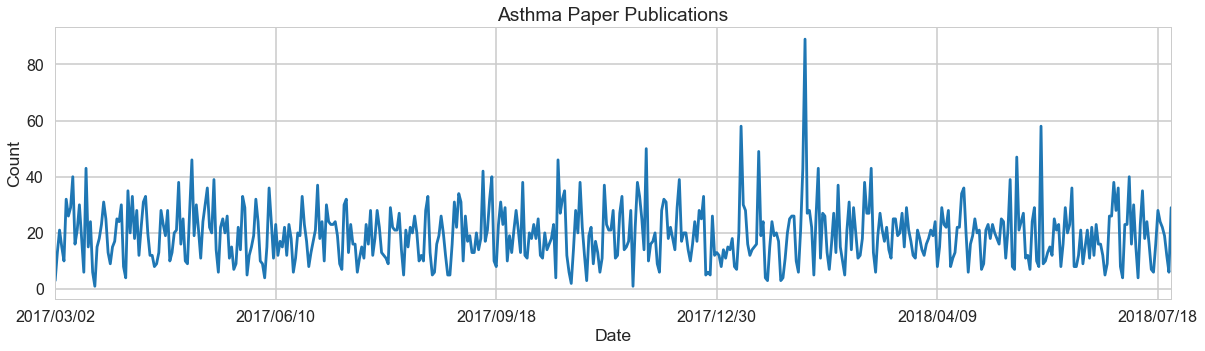

In [32]:
pubmed_df_counts = pubmed_df.groupby('crdt').size()    
pubmed_df_counts.plot(figsize=(20,5), title='Asthma Paper Publications')
plt.xlabel('Date')
plt.ylabel('Count')

In [11]:
#some parser functions for the abstract of pubmed articles
def get_methods(record):
    '''returns the METHODS: section of the record'''
    beginning_index = record['AB'].find("METHODS:")+len("METHODS:")
    ending_index = get_next_section_index(record['AB'][beginning_index:])
    return record['AB'][beginning_index:beginning_index + ending_index].strip()

def get_conclusion(record):
    '''returns CONCLUSION section of record'''
    #beginning_index = record['AB'].find("CONCLUSION:")+len("CONCLUSION:")
    conclusion_names = ["CONCLUSIONS:","CONCLUSION:", "Conclusion:"]
    beginning_index = max([re.search(i,record['AB'],re.IGNORECASE).end() \
                        for i in conclusion_names if re.search(i,record['AB'],re.IGNORECASE)])
    #print beginning_index
#     beginning_index = max([record['AB'].find("CONCLUSIONS:")+len("CONCLUSIONS:"),\
#                           record['AB'].find("CONCLUSION:")+len("CONCLUSION:")])
    ending_index = get_next_section_index(record['AB'][beginning_index:])
    return record['AB'][beginning_index:beginning_index + ending_index].strip()


def get_next_section_index(record_string):
    '''returns the next section index. Used to limit output of other get_section functions'''
    section_names = ["RATIONALE:","OBJECTIVES:","METHODS:","RESULTS:","CONCLUSION:",\
                    "OBJECTIVE:","METHOD:","RESULT:"]
    try:
        #ending_index = min([record_string.find(i) for i in section_names if record_string.find(i) > 0])
        ending_index = min([re.search(i,ss,re.IGNORECASE).start() for i in section_names if re.search(i,ss,re.IGNORECASE)])
        return ending_index
    except:
        #no more sections. return large number
        return 9999999

# def get_next_section_index2(record_string):
#     '''returns the next section index. Used to limit output of other get_section functions'''
#     section_names = ["RATIONALE:","OBJECTIVES:","METHODS:","RESULTS:","CONCLUSION:",\
#                     "OBJECTIVE:","METHOD:","RESULT:","BACKGROUND:"]
    
#     try:
#         ending_index = min()
#         ending_index = min([record_string.find(i) for i in section_names if record_string.find(i) > 0])
#         return ending_index
#     except:
#         #no more sections. return large number
#         return 9999999


In [14]:
records[len(records)-1]

{'AB': 'To advance the development of bronchodilators for asthma and chronic obstructive pulmonary disease (COPD), this study was designed to investigate the mechanism of functional antagonism between &beta;(2)-adrenergic and muscarinic M(2) receptors, focusing on allosteric effects and G proteins/ion channels coupling. Muscarinic receptor antagonists (tiotropium, glycopyrronium, atropine) synergistically enhanced the relaxant effects of &beta;(2)-adrenergic receptor agonists (procaterol, salbutamol, formoterol) in guinea pig trachealis. This crosstalk was inhibited by iberitoxin, a large-conductance Ca(2+)-activated K(+) (KCa) channel inhibitor, whereas it was increased by verapamil, a L-type voltage-dependent Ca(2+) (VDC) channel inhibitor; additionally, it was enhanced after tissues were incubated with pertussis or cholera toxin. This synergism converges in the G proteins (Gi, Gs)/KCa channel/VDC channel linkages. Muscarinic receptor antagonists competitively suppressed, whereas, &b

In [12]:
from gensim.summarization.summarizer import summarize

print records[len(records)-1]['AB']
print '\n'
print summarize(records[len(records)-1]['AB'])

To advance the development of bronchodilators for asthma and chronic obstructive pulmonary disease (COPD), this study was designed to investigate the mechanism of functional antagonism between &beta;(2)-adrenergic and muscarinic M(2) receptors, focusing on allosteric effects and G proteins/ion channels coupling. Muscarinic receptor antagonists (tiotropium, glycopyrronium, atropine) synergistically enhanced the relaxant effects of &beta;(2)-adrenergic receptor agonists (procaterol, salbutamol, formoterol) in guinea pig trachealis. This crosstalk was inhibited by iberitoxin, a large-conductance Ca(2+)-activated K(+) (KCa) channel inhibitor, whereas it was increased by verapamil, a L-type voltage-dependent Ca(2+) (VDC) channel inhibitor; additionally, it was enhanced after tissues were incubated with pertussis or cholera toxin. This synergism converges in the G proteins (Gi, Gs)/KCa channel/VDC channel linkages. Muscarinic receptor antagonists competitively suppressed, whereas, &beta;(2)-

In [13]:
ss = get_conclusion(records[len(records)-1])
# section_names = ["RATIONALE:","OBJECTIVES:","METHODS:","RESULTS:","CONCLUSION:",\
#                     "OBJECTIVE:","METHOD:","RESULT:","BACKGROUND:"]
# re.search("CONCLUSION:",ss,re.IGNORECASE).start()

# [re.search(i,ss,re.IGNORECASE).start() for i in section_names if re.search(i,ss,re.IGNORECASE)]
ss

ValueError: max() arg is an empty sequence

In [ ]:
re.search("Conclusion:", records[9]['AB'], re.IGNORECASE)

In [ ]:
for i, rec in enumerate(records):
    try:
        print i, get_conclusion(rec)
    except:
        print i
        continue

In [ ]:
get_methods(records[1])

In [ ]:
records[1]['AB']

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(get_conclusion(records[1]))

In [ ]:
tuples = []
for rec in records:
    try:
        conclusion = get_conclusion(rec)
    except:
        continue
    scores = sid.polarity_scores(conclusion)
    tuples.append((conclusion, scores, scores['compound']))

In [ ]:
df_scores = pd.DataFrame(tuples, columns=['conclusion','scores','compound'])

In [ ]:
df_scores.to_csv('scores.csv')

In [ ]:
records[1]